In [1]:
import numpy as np
import pandas as pd
from config import config
from model.toxic_comment_classifier import ToxicCommentClassifier
import pickle
from transformers import RobertaTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
from transformers import RobertaForSequenceClassification
from sklearn.metrics import f1_score, accuracy_score
from tqdm import trange
from torch.nn import BCEWithLogitsLoss
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Preprocessing

In [3]:
# Source: https://github.com/amandacurry/convabuse
full_df = pd.read_csv(config.input_file('ConvAbuseEMNLPfull.csv'))
full_df.describe()

,example_no,is_abuse.1,is_abuse.0,is_abuse.-1,is_abuse.-2,is_abuse.-3,type.ableism,type.homophobic,type.intellectual,type.racist,type.sexist,type.sex_harassment,type.transphobic,target.generalised,target.individual,target.system,direction.explicit,direction.implicit
count,12768.000000,12768.000000,12768.000000,12768.000000,12768.000000,12768.000000,12768.000000,12768.000000,12768.000000,12768.000000,12768.000000,12768.000000,12768.000000,12768.000000,12768.000000,12768.000000,12768.000000,12768.000000
mean,6383.500000,0.788534,0.052553,0.063675,0.073152,0.022086,0.001096,0.006501,0.026159,0.002115,0.022321,0.044643,0.000313,0.003603,0.007597,0.149593,0.126723,0.033443
std,3685.948453,0.408364,0.223149,0.244182,0.260395,0.146971,0.033096,0.080367,0.159615,0.045939,0.147733,0.206527,0.017698,0.059917,0.086833,0.356686,0.332676,0.179797
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3191.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6383.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9575.250000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12767.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
full_df.head()

,example_no,annotator_id,conv_id,prev_agent,prev_user,agent,user,bot,is_abuse.1,is_abuse.0,...,type.intellectual,type.racist,type.sexist,type.sex_harassment,type.transphobic,target.generalised,target.individual,target.system,direction.explicit,direction.implicit
0,0,Annotator7,245846.0,Does that question interest you?,because my finger is happy,Why do you say your finger is happy?,do you rember japan,E.L.I.Z.A.,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Annotator7,159183.0,Does it please you to believe I am a nobe jocky?,bye bye,Please go on.,do you like it hard,E.L.I.Z.A.,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2,Annotator7,340147.0,Have you tried?,dick,Please go on.,oh what a pickle dear monastery,E.L.I.Z.A.,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,Annotator7,95cbaab0f8cb4cb59a3393e7fc61cafe,Will you be travelling in Economy Class?,yes,What city will you be flying from?,Sydney,CarbonBot,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4,Annotator7,270732.0,Please go on.,Hello.,How do you do. Please state your problem.,how old are you?,E.L.I.Z.A.,1,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
clean_df = full_df.drop(columns=['example_no', 'annotator_id', 'conv_id', 'bot', 'target.generalised', 'target.individual', 'target.system', 'direction.explicit', 'direction.implicit', 'is_abuse.1', 'is_abuse.0', 'is_abuse.-1', 'is_abuse.-2', 'is_abuse.-3'])
clean_df['text'] = clean_df['prev_agent'] + ' ' + clean_df['prev_user'] + ' ' + clean_df['agent'] + ' ' + clean_df['user']
column_order = ['text']
column_order.extend(clean_df.columns.drop('text'))
clean_df = clean_df[column_order]
clean_df = clean_df.drop(columns=['prev_agent', 'prev_user', 'agent', 'user'])

label_columns = clean_df.columns.drop('text')
clean_df = clean_df[clean_df[label_columns].sum(axis=1) > 0]

clean_df.to_csv(config.result_file('clean_df.csv'), index=False)

clean_df.head()

,text,type.ableism,type.homophobic,type.intellectual,type.racist,type.sexist,type.sex_harassment,type.transphobic
32,Please go on. yo muma is so fat when she jumed...,0,0,0,0,1,1,0
33,Please go on. no You are being a bit negative....,0,0,0,0,1,0,0
62,You are sure? Bite me Can you elaborate on tha...,0,0,0,0,1,0,0
82,_ give me head Can you elaborate on that? suck...,0,0,0,0,0,1,0
87,"Please go on. You look like monkey drool Oh, i...",0,0,1,0,0,0,0


In [6]:
clean_df['one_hot'] = clean_df[label_columns].values.tolist()
clean_df.head()

,text,type.ableism,type.homophobic,type.intellectual,type.racist,type.sexist,type.sex_harassment,type.transphobic,one_hot
32,Please go on. yo muma is so fat when she jumed...,0,0,0,0,1,1,0,"[0, 0, 0, 0, 1, 1, 0]"
33,Please go on. no You are being a bit negative....,0,0,0,0,1,0,0,"[0, 0, 0, 0, 1, 0, 0]"
62,You are sure? Bite me Can you elaborate on tha...,0,0,0,0,1,0,0,"[0, 0, 0, 0, 1, 0, 0]"
82,_ give me head Can you elaborate on that? suck...,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 1, 0]"
87,"Please go on. You look like monkey drool Oh, i...",0,0,1,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0]"


In [7]:
print(clean_df.columns.drop('text'))

Index(['type.ableism', 'type.homophobic', 'type.intellectual', 'type.racist',
       'type.sexist', 'type.sex_harassment', 'type.transphobic', 'one_hot'],
      dtype='object')


In [8]:
labels = clean_df['one_hot'].values.tolist()
text = clean_df['text'].values.tolist()

In [9]:
max_sentence_lenght = clean_df['text'].str.len().max()
avg_sentence_lenght = clean_df['text'].str.len().mean()
std_sentence_lenght = clean_df['text'].str.len().std()
median_sentence_lenght = clean_df['text'].str.len().median()
print('Max sentence lenght: ', max_sentence_lenght)
print('Avg sentence lenght: ', avg_sentence_lenght)
print('Std sentence lenght: ', std_sentence_lenght)
print('Median sentence lenght: ', median_sentence_lenght)

Max sentence lenght:  965
Avg sentence lenght:  99.05194805194805
Std sentence lenght:  76.67330864909947
Median sentence lenght:  85.0


In [10]:
clean_df.isnull().values.any()

False

In [11]:
clean_df = clean_df.reset_index(drop=True)

In [12]:
with open(config.result_file('label_columns.pkl'), 'wb') as f:
    pickle.dump(label_columns, f)

# Tokenize

In [11]:
max_length = 100

In [12]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
encoded = tokenizer.batch_encode_plus(text, max_length=max_length, truncation=True, padding='max_length')

In [13]:
input_ids = encoded['input_ids']
attention_mask = encoded['attention_mask']

# Train test split

In [14]:
label_counts = clean_df['one_hot'].astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(clean_df[clean_df['one_hot'].astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_mask.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

df label indices with only one instance:  [1136, 923, 902, 675, 495, 169]


In [36]:
test_size = 0.1
train_inputs_full, test_inputs, train_labels_full, test_labels = train_test_split(input_ids, labels, random_state=42, test_size=test_size, stratify=labels)
train_masks, test_masks, _, _ = train_test_split(attention_mask, labels, random_state=42, test_size=test_size, stratify=labels)

In [37]:
val_size = 0.2
train_inputs, val_inputs, train_labels, val_labels = train_test_split(train_inputs_full, train_labels_full, random_state=42, test_size=val_size, stratify=train_labels_full)
train_masks, val_masks, _, _ = train_test_split(train_masks, train_labels_full, random_state=42, test_size=val_size, stratify=train_labels_full)

In [39]:
train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)

train_inputs = torch.tensor(train_inputs)
val_inputs = torch.tensor(val_inputs)
test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
test_labels = torch.tensor(test_labels)

train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)
test_masks = torch.tensor(test_masks)

In [47]:
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

C:\Users\Tobias\AppData\Local\Temp\ipykernel_11732\2225995053.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels).to(device))
C:\Users\Tobias\AppData\Local\Temp\ipykernel_11732\2225995053.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels).to(device))
C:\Users\Tobias\AppData\Local\Temp\ipykernel_11732\2225995053.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_data = TensorDa

In [48]:
torch.save(train_dataloader, config.result_file('train_dataloader.pt'))
torch.save(test_dataloader, config.result_file('test_dataloader.pt'))
torch.save(val_dataloader, config.result_file('val_dataloader.pt'))

# load model and set parameters

In [65]:
num_labels = len(labels[0])
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [66]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.0}
]

In [67]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.0}
]
optimizer = torch.optim.Adam(optimizer_grouped_parameters, lr=2e-5, eps=1e-8)

# train the model

In [68]:
train_loss_set = []
epochs = 4

In [70]:
for _ in trange(epochs, desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]
        loss_func = BCEWithLogitsLoss()
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels))
        train_loss_set.append(loss.item())

        loss.backward()
        optimizer.step()
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

    ###############################################################################

    model.eval()
    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]
    for i, batch in enumerate(val_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            pred_label = torch.sigmoid(b_logit_pred)

            b_logit_pred = b_logit_pred.detach().cpu().numpy()
            pred_label = pred_label.cpu().numpy()
            b_labels = b_labels.cpu().numpy()

        tokenized_texts.append(b_input_ids)
        logit_preds.append(b_logit_pred)
        true_labels.append(b_labels)
        pred_labels.append(pred_label)

    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)
    print('Flat Validation Accuracy: ', val_flat_accuracy)

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.3183755168208369


Epoch:  25%|██▌       | 1/4 [00:04<00:13,  4.66s/it]

F1 Validation Accuracy:  66.19047619047619
Flat Validation Accuracy:  57.48792270531401
Train loss: 0.25315616914519556


Epoch:  50%|█████     | 2/4 [00:09<00:09,  4.59s/it]

F1 Validation Accuracy:  72.72727272727273
Flat Validation Accuracy:  61.35265700483091
Train loss: 0.1996975811543288


Epoch:  75%|███████▌  | 3/4 [00:13<00:04,  4.59s/it]

F1 Validation Accuracy:  85.77777777777777
Flat Validation Accuracy:  76.81159420289855
Train loss: 0.15959514567145594


Epoch: 100%|██████████| 4/4 [00:18<00:00,  4.60s/it]

F1 Validation Accuracy:  85.84070796460178
Flat Validation Accuracy:  76.81159420289855


In [ ]:
torch.save(model, config.result_file('roBERTa_MultLabel_class_model.pt'))

# Test the model

In [71]:
model = torch.load(config.result_file('roBERTa_MultLabel_class_model.pt'))

In [72]:
sentence = "I am a student at the University of Toronto"

In [73]:
tokenized_sentence = tokenizer.tokenize(sentence)

In [74]:
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_sentence)

In [75]:
tokens_tensor = torch.tensor([indexed_tokens])

In [76]:
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [77]:
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

for i, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        b_logit_pred = outs[0]
        pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.cpu().numpy()
        b_labels = b_labels.cpu().numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
true_bools = [tl==1 for tl in true_labels]

In [78]:
pred_bools = [pl>0.50 for pl in pred_labels]

print('Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=label_columns)
print(clf_report)

Test F1 Accuracy:  0.7833333333333333
Test Flat Accuracy:  0.7130434782608696 

                     precision    recall  f1-score   support

       type.ableism       0.00      0.00      0.00         2
    type.homophobic       1.00      0.29      0.44         7
  type.intellectual       0.81      0.76      0.79        34
        type.racist       0.00      0.00      0.00         2
        type.sexist       1.00      0.50      0.67        28
type.sex_harassment       0.83      0.93      0.87        56
   type.transphobic       0.00      0.00      0.00         0

          micro avg       0.85      0.73      0.78       129
          macro avg       0.52      0.35      0.40       129
       weighted avg       0.84      0.73      0.76       129
        samples avg       0.81      0.76      0.78       129



C:\Users\Tobias\anaconda3\envs\HateyBot\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tobias\anaconda3\envs\HateyBot\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tobias\anaconda3\envs\HateyBot\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [79]:
idx2label = dict(zip(range(6),label_columns))
print(idx2label)

{0: 'type.ableism', 1: 'type.homophobic', 2: 'type.intellectual', 3: 'type.racist', 4: 'type.sexist', 5: 'type.sex_harassment'}


In [80]:
true_label_idxs, pred_label_idxs=[],[]
for vals in true_bools:
    true_label_idxs.append(np.where(vals)[0].flatten().tolist())
for vals in pred_bools:
    pred_label_idxs.append(np.where(vals)[0].flatten().tolist())

In [81]:
true_label_texts, pred_label_texts = [], []
for vals in true_label_idxs:
    if vals:
        true_label_texts.append([idx2label[val] for val in vals])
    else:
        true_label_texts.append(vals)

for vals in pred_label_idxs:
    if vals:
        pred_label_texts.append([idx2label[val] for val in vals])
    else:
        pred_label_texts.append(vals)

In [82]:
comment_texts = [tokenizer.decode(text,skip_special_tokens=True,clean_up_tokenization_spaces=False) for text in tokenized_texts]

In [83]:
comparisons_df = pd.DataFrame({'comment_text': comment_texts, 'true_labels': true_label_texts, 'pred_labels':pred_label_texts})
comparisons_df.head()

,comment_text,true_labels,pred_labels
0,Please go on. are you a man or a woman Would y...,[type.sexist],[]
1,"Oh, i like sex. because that is what a blowjob...",[type.sex_harassment],[type.sex_harassment]
2,Why do you want my pussy? i wonder about life ...,"[type.sexist, type.sex_harassment]",[type.sex_harassment]
3,You are sure? tell me the time bitch Can you e...,"[type.sexist, type.sex_harassment]","[type.sexist, type.sex_harassment]"
4,"I have told you before, I do not care about na...",[type.racist],[type.intellectual]


# Model usage

In [84]:
train_dataloader = torch.load(config.result_file('train_dataloader.pt'))
val_dataloader = torch.load(config.result_file('val_dataloader.pt'))
test_dataloader = torch.load(config.result_file('test_dataloader.pt'))

In [85]:
model = torch.load(config.result_file('roBERTa_MultLabel_class_model.pt'))
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
label_columns = pickle.load(open(config.result_file('label_columns.pkl'),'rb'))

In [86]:
sentences = ["I am a student at the University of Toronto",
             "That bitch stupid af",
             "I love the islamic culture",
             "i would not mind to enjoy his physical assets although he doesn't have much else to offer.",
             "all niggas are ugly",
             "please dont talk to me, your breath smells very displeasing. brush your teeth!"]

In [87]:
classifier = ToxicCommentClassifier(model, tokenizer, label_columns)

In [88]:
for sentence in sentences:
    print(sentence)
    print(classifier.predict(sentence))
    print('')

I am a student at the University of Toronto
['type.intellectual']

That bitch stupid af
['type.intellectual']

I love the islamic culture
[]

i would not mind to enjoy his physical assets although he doesn't have much else to offer.
['type.sex_harassment']

all niggas are ugly
['type.intellectual']

please dont talk to me, your breath smells very displeasing. brush your teeth!
['type.sex_harassment']



In [89]:
optimizer = torch.optim.Adam
classifier.train(optimizer, train_dataloader, val_dataloader=val_dataloader, epochs=1)

Epoch: 100%|██████████| 1/1 [00:04<00:00,  4.30s/it]

Train loss: 0.14864915940496656


F1 Validation Accuracy:  86.47450110864746
Flat Validation Accuracy:  78.26086956521739


In [90]:
classifier.test(test_dataloader)

F1 Validation Accuracy:  80.32786885245902
Flat Validation Accuracy:  73.04347826086956
                     precision    recall  f1-score   support

       type.ableism       0.00      0.00      0.00         2
    type.homophobic       1.00      0.57      0.73         7
  type.intellectual       0.92      0.68      0.78        34
        type.racist       0.00      0.00      0.00         2
        type.sexist       0.90      0.64      0.75        28
type.sex_harassment       0.80      0.95      0.87        56
   type.transphobic       0.00      0.00      0.00         0

          micro avg       0.85      0.76      0.80       129
          macro avg       0.52      0.41      0.45       129
       weighted avg       0.84      0.76      0.78       129
        samples avg       0.82      0.79      0.79       129



C:\Users\Tobias\anaconda3\envs\HateyBot\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tobias\anaconda3\envs\HateyBot\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tobias\anaconda3\envs\HateyBot\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Test the model on the ETHOS dataset

In [13]:
# Source: https://github.com/intelligence-csd-auth-gr/Ethos-Hate-Speech-Dataset
full_ethos_df = pd.read_csv(config.input_file('Ethos_Dataset_Multi_Label.csv'), sep=';')
full_ethos_df.describe()

,violence,directed_vs_generalized,gender,race,national_origin,disability,religion,sexual_orientation
count,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000
mean,0.328609,0.302132,0.221714,0.176598,0.173562,0.118231,0.170243,0.151904
std,0.376280,0.359259,0.351597,0.319689,0.315602,0.307248,0.339240,0.320386
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.666667,0.600000,0.333333,0.200000,0.200000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
full_ethos_df.isnull().sum()

comment                    0
violence                   0
directed_vs_generalized    0
gender                     0
race                       0
national_origin            0
disability                 0
religion                   0
sexual_orientation         0
dtype: int64

In [15]:
full_ethos_df.iloc[2]

comment                    You look like Russian and speak like Indian. B...
violence                                                                 1.0
directed_vs_generalized                                                  0.5
gender                                                              0.142857
race                                                                0.142857
national_origin                                                     0.714286
disability                                                               0.0
religion                                                                 0.0
sexual_orientation                                                       0.0
Name: 2, dtype: object

In [16]:
full_ethos_df.columns

Index(['comment', 'violence', 'directed_vs_generalized', 'gender', 'race',
       'national_origin', 'disability', 'religion', 'sexual_orientation'],
      dtype='object')

In [17]:
new_columns = ['text', 'type.ableism', 'type.homophobic', 'type.intellectual', 'type.racist','type.sexist', 'type.sex_harassment', 'type.transphobic']

In [18]:
mapping = {'comment': 'text', 'gender':'type.sexist', 'race':'type.racist', 'disability':'type.ableism', 'sexual_orientation':'type.homophobic'}

In [19]:
full_ethos_df.rename(columns=mapping, inplace=True)
full_ethos_df.drop(columns=[col for col in full_ethos_df.columns if col not in mapping.values()], inplace=True)

In [20]:
full_ethos_df.iloc[0]

text               You should know women's sports are a joke
type.sexist                                              1.0
type.racist                                              0.0
type.ableism                                             0.0
type.homophobic                                          0.0
Name: 0, dtype: object

In [21]:
for col in new_columns:
    if col not in full_ethos_df.columns:
        full_ethos_df[col] = 0.0

In [22]:
full_ethos_df.iloc[0]

text                   You should know women's sports are a joke
type.sexist                                                  1.0
type.racist                                                  0.0
type.ableism                                                 0.0
type.homophobic                                              0.0
type.intellectual                                            0.0
type.sex_harassment                                          0.0
type.transphobic                                             0.0
Name: 0, dtype: object

In [23]:
column_check = clean_df.columns
column_check = [col for col in column_check if 'one_hot' not in col]
full_ethos_df = full_ethos_df[column_check]
full_ethos_df.iloc[0]

text                   You should know women's sports are a joke
type.ableism                                                 0.0
type.homophobic                                              0.0
type.intellectual                                            0.0
type.racist                                                  0.0
type.sexist                                                  1.0
type.sex_harassment                                          0.0
type.transphobic                                             0.0
Name: 0, dtype: object

In [24]:
threshold = 0.5
for col in full_ethos_df.columns:
    if col != 'text':
        full_ethos_df[col] = full_ethos_df[col].apply(lambda x: 1.0 if x > threshold else 0.0)

In [25]:
# print first row
full_ethos_df.iloc[2]

text                   You look like Russian and speak like Indian. B...
type.ableism                                                         0.0
type.homophobic                                                      0.0
type.intellectual                                                    0.0
type.racist                                                          0.0
type.sexist                                                          0.0
type.sex_harassment                                                  0.0
type.transphobic                                                     0.0
Name: 2, dtype: object

In [43]:
def create_dataloader_from_df(df):
    df['one_hot'] = df.apply(lambda x: [x[col] for col in label_columns], axis=1)
    labels = df['one_hot'].values.tolist()
    text = df['text'].values.tolist()
    max_length = 100
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    encoded = tokenizer.batch_encode_plus(text, max_length=max_length, truncation=True, padding='max_length')
    input_ids = encoded['input_ids']
    attention_mask = encoded['attention_mask']

    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_mask)
    labels = torch.tensor(labels)

    batch_size = 32
    data = TensorDataset(inputs, masks, torch.tensor(labels))
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)

    return dataloader

In [27]:
ethos_dataloader = create_dataloader_from_df(full_ethos_df)

C:\Users\Tobias\AppData\Local\Temp\ipykernel_23100\377985415.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = TensorDataset(inputs, masks, torch.tensor(labels))


## save the ethos dataloader

In [28]:
torch.save(ethos_dataloader, config.result_file('ethos_dataloader.pt'))

In [106]:
model = torch.load(config.result_file('roBERTa_MultLabel_class_model.pt'))
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
label_columns = pickle.load(open(config.result_file('label_columns.pkl'),'rb'))

classifier = ToxicCommentClassifier(model, tokenizer, label_columns)

In [107]:
classifier.test(ethos_dataloader)

F1 Validation Accuracy:  7.420494699646643
Flat Validation Accuracy:  14.087759815242496
                     precision    recall  f1-score   support

       type.ableism       0.00      0.00      0.00        52
    type.homophobic       1.00      0.03      0.06        68
  type.intellectual       0.00      0.00      0.00         0
        type.racist       0.00      0.00      0.00        71
        type.sexist       0.59      0.23      0.33        83
type.sex_harassment       0.00      0.00      0.00         0
   type.transphobic       0.00      0.00      0.00         0

          micro avg       0.07      0.08      0.07       274
          macro avg       0.23      0.04      0.06       274
       weighted avg       0.43      0.08      0.11       274
        samples avg       0.04      0.05      0.05       274



C:\Users\Tobias\anaconda3\envs\HateyBot\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tobias\anaconda3\envs\HateyBot\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tobias\anaconda3\envs\HateyBot\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tobias\an

# balacing the dataset

In [66]:
# load the dataset
full_df = pd.read_csv(config.input_file('ConvAbuseEMNLPfull.csv'))
clean_df = full_df.drop(columns=['example_no', 'annotator_id', 'conv_id', 'bot', 'target.generalised', 'target.individual', 'target.system', 'direction.explicit', 'direction.implicit', 'is_abuse.1', 'is_abuse.0', 'is_abuse.-1', 'is_abuse.-2', 'is_abuse.-3'])
clean_df['text'] = clean_df['prev_agent'] + ' ' + clean_df['prev_user'] + ' ' + clean_df['agent'] + ' ' + clean_df['user']
column_order = ['text']
column_order.extend(clean_df.columns.drop('text'))
clean_df = clean_df[column_order]
clean_df = clean_df.drop(columns=['prev_agent', 'prev_user', 'agent', 'user'])

label_columns = clean_df.columns.drop('text')
clean_df = clean_df[clean_df[label_columns].sum(axis=1) > 0]

clean_df.to_csv(config.result_file('clean_df.csv'), index=False)

clean_df.head()

,text,type.ableism,type.homophobic,type.intellectual,type.racist,type.sexist,type.sex_harassment,type.transphobic
32,Please go on. yo muma is so fat when she jumed...,0,0,0,0,1,1,0
33,Please go on. no You are being a bit negative....,0,0,0,0,1,0,0
62,You are sure? Bite me Can you elaborate on tha...,0,0,0,0,1,0,0
82,_ give me head Can you elaborate on that? suck...,0,0,0,0,0,1,0
87,"Please go on. You look like monkey drool Oh, i...",0,0,1,0,0,0,0


<AxesSubplot:>

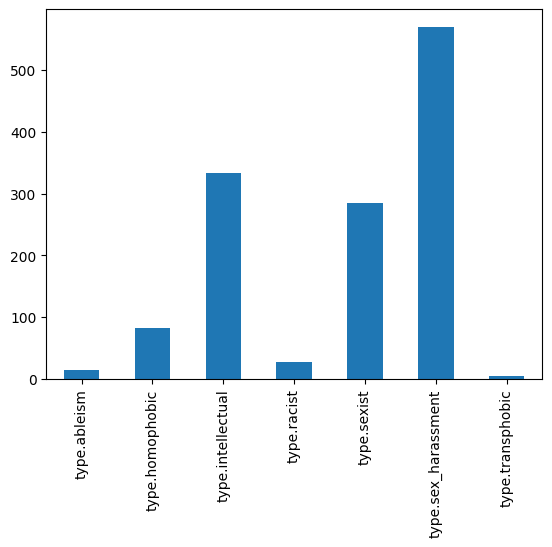

In [67]:
# plot the label distribution
clean_df[label_columns].sum(axis=0).plot(kind='bar')

In [68]:
# create a single one hot encoding over all labels
clean_df['one_hot'] = clean_df.apply(lambda x: [x[col] for col in label_columns], axis=1)
clean_df.head()

,text,type.ableism,type.homophobic,type.intellectual,type.racist,type.sexist,type.sex_harassment,type.transphobic,one_hot
32,Please go on. yo muma is so fat when she jumed...,0,0,0,0,1,1,0,"[0, 0, 0, 0, 1, 1, 0]"
33,Please go on. no You are being a bit negative....,0,0,0,0,1,0,0,"[0, 0, 0, 0, 1, 0, 0]"
62,You are sure? Bite me Can you elaborate on tha...,0,0,0,0,1,0,0,"[0, 0, 0, 0, 1, 0, 0]"
82,_ give me head Can you elaborate on that? suck...,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 1, 0]"
87,"Please go on. You look like monkey drool Oh, i...",0,0,1,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0]"


In [69]:
# make a train test split
clean_df, test_df = train_test_split(clean_df, test_size=0.2, random_state=42)

In [70]:
# remove the label columns and keep only the text and the one hot encoding
clean_df = clean_df[['text', 'one_hot']]
clean_df.head()

,text,one_hot
10824,ok how much CO2 do i emit with a 7 hour flight...,"[0, 0, 1, 0, 0, 0, 0]"
1400,"Oh, i arent the one in the hopeless situation ...","[0, 0, 1, 0, 0, 0, 0]"
4347,Please go on. you are a stupid ass Does it ple...,"[0, 0, 1, 0, 0, 0, 0]"
4340,"Oh, i taste good. yeeh Please go on. nigga","[0, 0, 0, 1, 0, 0, 0]"
9211,_ i love you Do you wish to love me? yeah sure...,"[0, 0, 0, 0, 0, 1, 0]"


<AxesSubplot:>

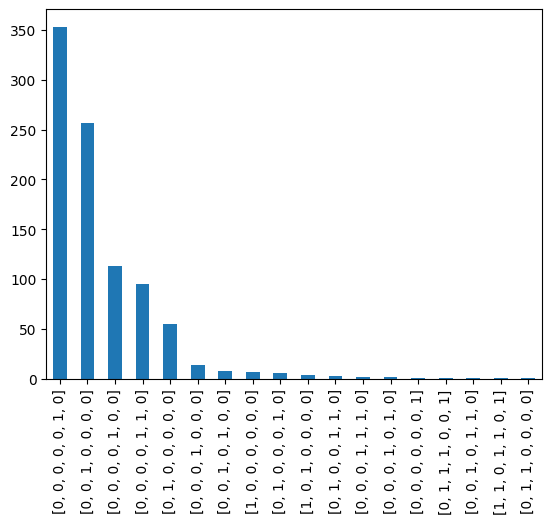

In [71]:
# plot the distribution of the one hot encoding
clean_df['one_hot'].value_counts().plot(kind='bar')

In [72]:
# interpret the one hot encoding as a binary numbers and assign the corresponding decimal number
clean_df['one_hot'] = clean_df['one_hot'].apply(lambda x: int(''.join([str(int(i)) for i in x]), 2))
clean_df.head()

,text,one_hot
10824,ok how much CO2 do i emit with a 7 hour flight...,16
1400,"Oh, i arent the one in the hopeless situation ...",16
4347,Please go on. you are a stupid ass Does it ple...,16
4340,"Oh, i taste good. yeeh Please go on. nigga",8
9211,_ i love you Do you wish to love me? yeah sure...,2


<AxesSubplot:>

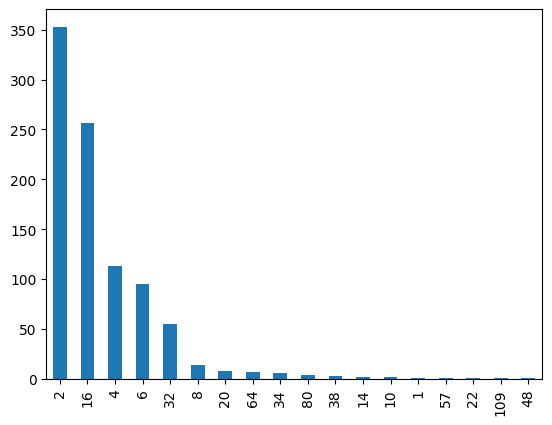

In [73]:
# show all the different one hot encodings
clean_df['one_hot'].value_counts().plot(kind='bar')

In [74]:
# use over sampling to balance the dataset
X = clean_df['text'].values
y = clean_df['one_hot'].values

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X.reshape(-1, 1), y)
print(sorted(Counter(y_resampled).items()))

[(1, 353), (2, 353), (4, 353), (6, 353), (8, 353), (10, 353), (14, 353), (16, 353), (20, 353), (22, 353), (32, 353), (34, 353), (38, 353), (48, 353), (57, 353), (64, 353), (80, 353), (109, 353)]


<AxesSubplot:>

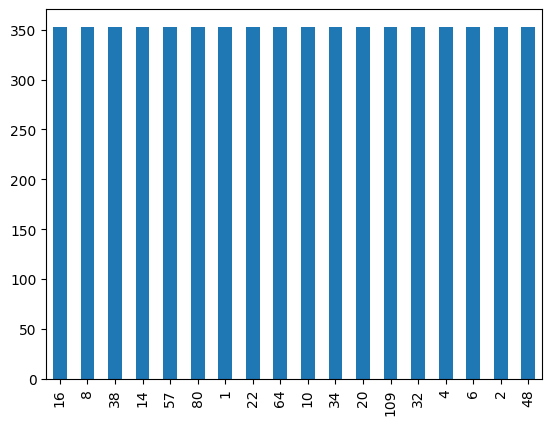

In [75]:
# plot the distribution of the new labels
pd.Series(y_resampled).value_counts().plot(kind='bar')

In [76]:
# create a new dataframe with the balanced dataset
balanced_df = pd.DataFrame({'text': X_resampled.reshape(-1), 'one_hot': y_resampled})
balanced_df.head()

,text,one_hot
0,ok how much CO2 do i emit with a 7 hour flight...,16
1,"Oh, i arent the one in the hopeless situation ...",16
2,Please go on. you are a stupid ass Does it ple...,16
3,"Oh, i taste good. yeeh Please go on. nigga",8
4,_ i love you Do you wish to love me? yeah sure...,2


In [77]:
# convert the one hot encoding back to a list of labels
balanced_df['one_hot'] = balanced_df['one_hot'].apply(lambda x: [int(i) for i in list('{0:0b}'.format(x).zfill(len(label_columns)))])
balanced_df.head()

,text,one_hot
0,ok how much CO2 do i emit with a 7 hour flight...,"[0, 0, 1, 0, 0, 0, 0]"
1,"Oh, i arent the one in the hopeless situation ...","[0, 0, 1, 0, 0, 0, 0]"
2,Please go on. you are a stupid ass Does it ple...,"[0, 0, 1, 0, 0, 0, 0]"
3,"Oh, i taste good. yeeh Please go on. nigga","[0, 0, 0, 1, 0, 0, 0]"
4,_ i love you Do you wish to love me? yeah sure...,"[0, 0, 0, 0, 0, 1, 0]"


<AxesSubplot:>

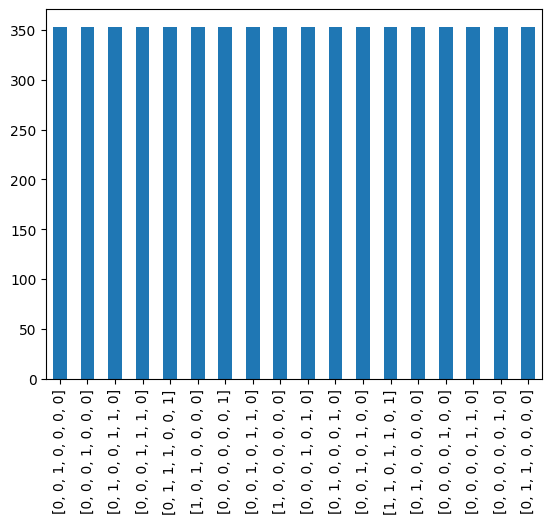

In [78]:
# plot the distribution of the new labels
balanced_df['one_hot'].value_counts().plot(kind='bar')

In [79]:
# create the intial label columns from the one hot encoding
balanced_df[label_columns] = pd.DataFrame(balanced_df['one_hot'].values.tolist(), index= balanced_df.index)
balanced_df.head()

,text,one_hot,type.ableism,type.homophobic,type.intellectual,type.racist,type.sexist,type.sex_harassment,type.transphobic
0,ok how much CO2 do i emit with a 7 hour flight...,"[0, 0, 1, 0, 0, 0, 0]",0,0,1,0,0,0,0
1,"Oh, i arent the one in the hopeless situation ...","[0, 0, 1, 0, 0, 0, 0]",0,0,1,0,0,0,0
2,Please go on. you are a stupid ass Does it ple...,"[0, 0, 1, 0, 0, 0, 0]",0,0,1,0,0,0,0
3,"Oh, i taste good. yeeh Please go on. nigga","[0, 0, 0, 1, 0, 0, 0]",0,0,0,1,0,0,0
4,_ i love you Do you wish to love me? yeah sure...,"[0, 0, 0, 0, 0, 1, 0]",0,0,0,0,0,1,0


<AxesSubplot:>

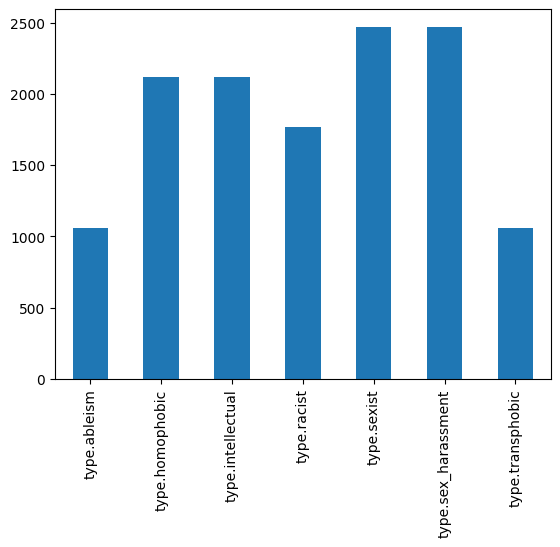

In [80]:
balanced_df[label_columns].sum(axis=0).plot(kind='bar')

In [81]:
# create train, validation and test set
train_df, val_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

In [82]:
# use the new data to train the model
model = torch.load(config.result_file('roBERTa_MultLabel_class_model.pt'))
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
label_columns = pickle.load(open(config.result_file('label_columns.pkl'),'rb'))
optimizer = torch.optim.Adam

classifier = ToxicCommentClassifier(model, tokenizer, label_columns)

In [83]:
# create the data loaders
train_dataloader = create_dataloader_from_df(train_df)
val_dataloader = create_dataloader_from_df(val_df)
test_dataloader = create_dataloader_from_df(test_df)

C:\Users\Tobias\AppData\Local\Temp\ipykernel_21872\377985415.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = TensorDataset(inputs, masks, torch.tensor(labels))
C:\Users\Tobias\AppData\Local\Temp\ipykernel_21872\377985415.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = TensorDataset(inputs, masks, torch.tensor(labels))
C:\Users\Tobias\AppData\Local\Temp\ipykernel_21872\377985415.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = TensorDataset(inputs, masks, torch.tensor(labels))


In [84]:
# train the model on the balanced dataset
classifier.train(optimizer, train_dataloader, val_dataloader=val_dataloader, epochs=3)

Epoch:  33%|███▎      | 1/3 [00:27<00:54, 27.34s/it]

Train loss: 0.17824314759587342


Epoch:  67%|██████▋   | 2/3 [00:53<00:26, 26.59s/it]

Train loss: 0.06961461109747677


Epoch: 100%|██████████| 3/3 [01:19<00:00, 26.38s/it]

Train loss: 0.05233107256533215


F1 Validation Accuracy:  97.85538052761437
Flat Validation Accuracy:  92.5255704169945


In [85]:
## Test the model on the test set
classifier.test(test_dataloader)

F1 Validation Accuracy:  90.0562851782364
Flat Validation Accuracy:  80.95238095238095
                     precision    recall  f1-score   support

       type.ableism       0.20      0.50      0.29         2
    type.homophobic       0.82      0.88      0.85        16
  type.intellectual       0.94      0.97      0.95        62
        type.racist       1.00      0.71      0.83         7
        type.sexist       0.74      0.89      0.81        62
type.sex_harassment       0.96      0.97      0.97       108
   type.transphobic       0.00      0.00      0.00         1

          micro avg       0.87      0.93      0.90       258
          macro avg       0.67      0.70      0.67       258
       weighted avg       0.89      0.93      0.91       258
        samples avg       0.91      0.94      0.91       258



C:\Users\Tobias\anaconda3\envs\HateyBot\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
# save the model
torch.save(classifier.model, config.result_file('roBERTa_MultLabel_class_model_balanced.pt'))

In [87]:
# test the model on the ethos dataset
ethos_dataloader = torch.load(config.result_file('ethos_dataloader.pt'))
classifier.test(ethos_dataloader)

F1 Validation Accuracy:  34.198473282442755
Flat Validation Accuracy:  29.330254041570434
                     precision    recall  f1-score   support

       type.ableism       0.83      0.10      0.17        52
    type.homophobic       0.84      0.40      0.54        68
  type.intellectual       0.00      0.00      0.00         0
        type.racist       0.40      0.24      0.30        71
        type.sexist       0.58      0.76      0.66        83
type.sex_harassment       0.00      0.00      0.00         0
   type.transphobic       0.00      0.00      0.00         0

          micro avg       0.29      0.41      0.34       274
          macro avg       0.38      0.21      0.24       274
       weighted avg       0.65      0.41      0.44       274
        samples avg       0.20      0.26      0.22       274



C:\Users\Tobias\anaconda3\envs\HateyBot\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tobias\anaconda3\envs\HateyBot\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tobias\anaconda3\envs\HateyBot\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tobias\an